In [1]:
%load_ext autoreload

In [103]:
%autoreload 2
from delase import DeLASE
from delase.metrics import mase
import h5py
from hydra import initialize, compose
import matplotlib.pyplot as plt
import os
import pandas as pd
from scipy.stats import pearsonr, spearmanr, wilcoxon
import sys
import torch
import numpy as np
from tqdm.auto import tqdm

from UniversalUnconsciousness.data_utils import get_agent_data, get_grid_params_to_use, find_noisy_data, get_noise_filter_info
from UniversalUnconsciousness.hdf5_utils import *
from UniversalUnconsciousness.iaaft import surrogates
from UniversalUnconsciousness.plot_utils import *

load_font()
plt.style.use('UniversalUnconsciousness.sci_style')

In [3]:
with initialize(version_base="1.3", config_path="../../UniversalUnconsciousness/DeLASE_analysis/conf"):
    cfg = compose(config_name="config")

In [ ]:
# all_data_dir = '/orcd/data/ekmiller/001/common/datasets'

cfg.params.stride = 15
cfg.params.window = 15

In [5]:
agent_data = get_agent_data(cfg, use_individiual_areas=False, verbose=False)

  0%|          | 0/3 [00:00<?, ?it/s]

Only 1 valid windows could be found for section 'awake lever1' with times [np.float64(-36.120676111111116), np.float64(-26.045618333333337)]


In [ ]:
top_percent = 0.1
limit_time = 45 # minutes post infusion

total_its = 0
for data_class, agent in cfg.plotting.anesthetic_agent_list:
    for monkey in agent_data[(data_class, agent)]['session_lists']:
        for session in agent_data[(data_class, agent)]['session_lists'][monkey]['high']:
            total_its += 1

iterator = tqdm(total=total_its)

physiology_corrs = {}
for data_class, agent in cfg.plotting.anesthetic_agent_list:
    physiology_corrs[(data_class, agent)] = {}
    if data_class == 'propofolPuffTone':
        data_dir = os.path.join(cfg.params.all_data_dir, 'anesthesia', 'mat', data_class)
        cfg.params.data_class = 'propofolPuffTone'
        cfg.params.grid_set = 'grid_set6'
    else:
        data_dir = os.path.join(cfg.params.all_data_dir, data_class, 'mat')
        cfg.params.data_class = 'anesthesiaLvrOdd'
        cfg.params.grid_set = 'grid_set6'
    
    for j, monkey in enumerate(agent_data[(data_class, agent)]['session_lists']):
        physiology_corrs[(data_class, agent)][monkey] = {}
        for session in agent_data[(data_class, agent)]['session_lists'][monkey]['high']:

            section_info, section_info_extended, section_colors, infusion_start = get_section_info(session, cfg.params.all_data_dir, cfg.params.data_class)

            session_file = h5py.File(os.path.join(data_dir,f"{session}.mat"), 'r')

            dt = session_file['lfpSchema']['smpInterval'][0, 0]
            if data_class == 'propofolPuffTone':
                infusion_start = session_file['sessionInfo']['drugStart'][0, 0]
            else:
                infusion_start = session_file['sessionInfo']['infusionStart'][0, 0]

            dim_ref = session_file[session_file['ainSchema']['index'][1, 0]][:]
            dim_names = [convert_char_array(session_file[dim_ref[i][0]][:]).split('.')[-1] for i in range(dim_ref.shape[0])]

            try:
                if agent in ['ketamine', 'dexmedetomidine']:
                    # phys_dim = np.where([name == 'SpO2' for name in dim_names])[0][0]
                    phys_dim = np.where([name == 'pupilSize' for name in dim_names])[0][0]
                else:
                    phys_dim = np.where([name == 'EMG' for name in dim_names])[0][0]
            except IndexError:
               print(f'{session} has no physiology channel (dim names: {dim_names}, could not find {"EMG" if agent not in ["ketamine", "dexmedetomidine"] else "pupilSize"})')
               iterator.update(1)
               continue
            phys_time_series = np.abs(session_file['ain'][phys_dim])
            time_phys = np.arange(phys_time_series.shape[0])*dt
            delase_results = agent_data[(data_class, agent)]['delase_results'][session]['all']
            stab_params = delase_results.stability_params.apply(lambda x: x[:int(len(x)*top_percent)].mean())
            window_starts = delase_results.window_start

            block_phys_time_series = []
            for i, row in delase_results.iterrows():
                window_start, window_end = row['window_start'], row['window_end']
                start_index, end_index = int(window_start/dt), int(window_end/dt)
                if end_index < phys_time_series.shape[0] and infusion_start + limit_time*60 > window_end:
                    block_phys_time_series.append(np.nanmean(phys_time_series[start_index:end_index]))
            block_phys_time_series = np.array(block_phys_time_series)

            min_len = min(len(stab_params), len(block_phys_time_series))
            pearson_corr, p_pearson = pearsonr(stab_params[:min_len], block_phys_time_series[:min_len])
            spearman_corr, p_spearman = spearmanr(stab_params[:min_len], block_phys_time_series[:min_len])
            physiology_corrs[(data_class, agent)][monkey][session] = {
                'pearson_corr': pearson_corr,
                'p_pearson': p_pearson,
                'spearman_corr': spearman_corr,
                'p_spearman': p_spearman
            }
            iterator.update(1)
iterator.close()

  0%|          | 0/53 [00:00<?, ?it/s]

SPOCK_Ketamine_20210707 has no physiology channel (dim names: ['SpO2', 'audio'], could not find pupilSize)


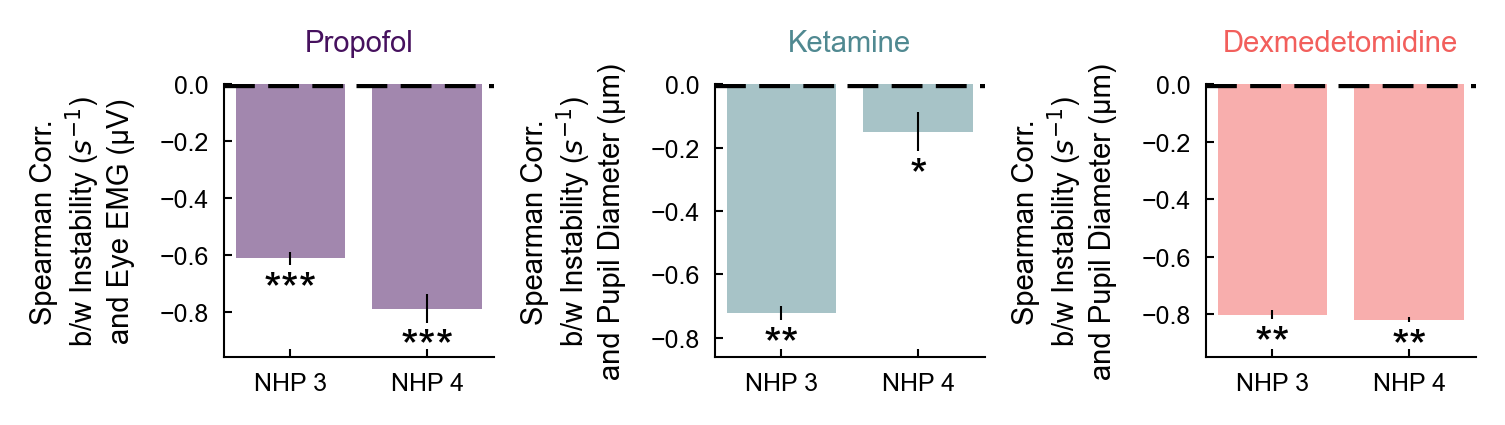

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(5, 1.4))

def significance_stars(p):
    if p < 0.0001:
        return "****"
    elif p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return ""

corr_to_use = 'spearman'

for i, (data_class, agent) in enumerate(physiology_corrs):
    for j, monkey in enumerate(physiology_corrs[(data_class, agent)]):
        # Get all correlations for this monkey\
        if corr_to_use == 'pearson':
            corrs = [d['pearson_corr'] for d in physiology_corrs[(data_class, agent)][monkey].values()]
        elif corr_to_use == 'spearman':
            corrs = [d['spearman_corr'] for d in physiology_corrs[(data_class, agent)][monkey].values()]
        else:
            raise ValueError(f"Invalid correlation type: {corr_to_use}")
        wilcoxon_result = wilcoxon(corrs, np.zeros(len(corrs)), alternative='less')
        wilcoxon_p = wilcoxon_result.pvalue if hasattr(wilcoxon_result, 'pvalue') else wilcoxon_result[1]

        bar_label = f"NHP {j + 1 if agent == 'propofolPuffTone' else j + 3}"
        bar_val = np.mean(corrs)
        bar_err = np.std(corrs) / np.sqrt(len(corrs))
        bar = axs[i].bar(bar_label, bar_val, yerr=bar_err, alpha=0.5)

        # change bar color
        for rect in bar.patches:
            rect.set_facecolor(cfg.plotting.curve_colors[agent])
        
        # Add significance stars above the bar
        star_text = significance_stars(wilcoxon_p)
        if star_text:
            bar_height = bar.patches[0].get_height()
            yerr = bar_err
            y = bar_height - yerr - 0.02  # 0.02 offset for visibility
            axs[i].text(bar.patches[0].get_x() + bar.patches[0].get_width()/2, y, star_text, ha='center', va='top', fontsize=11)
        if i == 0:
            if corr_to_use == 'pearson':
                axs[i].set_ylabel("Pearson Corr.\n" + r"b/w Instability ($s^{-1}$)" + "\nand Eye EMG (μV)", fontsize=7)
            elif corr_to_use == 'spearman':
                axs[i].set_ylabel("Spearman Corr.\n" + r"b/w Instability ($s^{-1}$)" + "\nand Eye EMG (μV)", fontsize=7)
            axs[i].set_title(f"{agent.capitalize()}", fontsize=7, color=cfg.plotting.curve_colors[agent])
        else:
            if corr_to_use == 'pearson':
                axs[i].set_ylabel("Pearson Corr.\n" + r"b/w Instability ($s^{-1}$)" + "\nand Pupil Diameter (μm)", fontsize=7)
            elif corr_to_use == 'spearman':
                axs[i].set_ylabel("Spearman Corr.\n" + r"b/w Instability ($s^{-1}$)" + "\nand Pupil Diameter (μm)", fontsize=7)
            axs[i].set_title(f"{agent.capitalize()}", fontsize=7, color=cfg.plotting.curve_colors[agent])
    ylim = axs[i].get_ylim()
    axs[i].set_ylim(ylim[0] - 0.08, ylim[1])
    axs[i].axhline(0, color='black', linewidth=2, linestyle='--')
plt.tight_layout()

In [151]:
corrs

[np.float64(-0.06083852895670014),
 np.float64(0.16608280277271167),
 np.float64(0.07291019482214907),
 np.float64(0.020975736049270274),
 np.float64(0.1387554283830475),
 np.float64(0.18677933726737542),
 np.float64(-0.0807733303209775)]